Connected to openmm (Python 3.10.15)

In [ ]:
#########################################################################
########### CREATOR: SEBASTIAN KORSAK, WARSAW 2024 ######################
#########################################################################

from matplotlib.pyplot import figure
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance
from tqdm import tqdm
import pyBigWig
import random as rd
from itertools import groupby
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None

chrs = {0:'chr1',1:'chr2',2:'chr3',3:'chr4',4:'chr5',5:'chr6',6:'chr7',7:'chr8',
          8:'chr9',9:'chr10',10:'chr11',11:'chr12',12:'chr13',13:'chr14',14:'chr15',
          15:'chr16',16:'chr17',17:'chr18',18:'chr19',19:'chr20',20:'chr21',21:'chr22',
          22:'chrX',23:'chrY'}

chrom_lengths_array = np.array([0,248387328,242696752,201105948,193574945,
                 182045439,172126628,160567428,146259331,
                 150617247,134758134,135127769,133324548,
                 113566686,101161492,99753195,96330374,
                 84276897,80542538,61707364,66210255,
                 45090682,51324926,154259566,62460029])

chrom_sizes = {'chr1':248387328,'chr2':242696752,'chr3':201105948,'chr4':193574945,
               'chr5':182045439,'chr6':172126628,'chr7':160567428,'chr8':146259331,
               'chr9':150617247,'chr10':134758134,'chr11':135127769,'chr12':133324548,
               'chr13':113566686,'chr14':101161492,'chr15':99753195,'chr16':96330374,
               'chr17':84276897,'chr18':80542538,'chr19':61707364,'chr20':66210255,
               'chr21':45090682,'chr22':51324926,'chrX':154259566,'chrY':62460029}

def min_max_normalize(matrix, Min=0, Max=1):
    # Calculate the minimum and maximum values of the matrix
    matrix = np.nan_to_num(matrix)
    min_val = np.min(matrix)
    max_val = np.max(matrix)

    # Normalize the matrix using the min-max formula
    normalized_matrix = Min + (Max - Min) * ((matrix - min_val) / (max_val - min_val))

    return normalized_matrix

chrom_strength = 1-min_max_normalize(chrom_lengths_array[1:])

def get_coordinates_mm(mm_vec):
    '''
    It returns the corrdinate matrix V (N,3) of a .pdb file.
    The main problem of this function is that coordiantes are not always in 
    the same column position of a .pdb file. Do changes appropriatelly,
    in case that the data aren't stored correctly. 
    
    Input:
    file (Openmm Qunatity): an OpenMM vector of the form
    Quantity(value=[Vec3(x=0.16963918507099152, y=0.9815883636474609, z=-1.4776774644851685), 
    Vec3(x=0.1548253297805786, y=0.9109517931938171, z=-1.4084612131118774), 
    Vec3(x=0.14006929099559784, y=0.8403329849243164, z=-1.3392155170440674), 
    Vec3(x=0.12535107135772705, y=0.7697405219078064, z=-1.269935131072998),
    ...,
    unit=nanometer)
    
    Output:
    V (np.array): the matrix of coordinates
    '''
    V = list()

    for i in range(len(mm_vec)):
        x, y ,z = mm_vec[i][0]._value, mm_vec[i][1]._value, mm_vec[i][2]._value
        V.append([x, y, z])
    
    return np.array(V)

def get_coordinates_cif(file):
    '''
    It returns the corrdinate matrix V (N,3) of a .pdb file.
    The main problem of this function is that coordiantes are not always in 
    the same column position of a .pdb file. Do changes appropriatelly,
    in case that the data aren't stored correctly. 
    
    Input:
    file (str): the path of the .cif file.
    
    Output:
    V (np.array): the matrix of coordinates
    '''
    V = list()
    
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("ATOM"):
                columns = line.split()
                x = eval(columns[10])
                y = eval(columns[11])
                z = eval(columns[12])
                V.append([x, y, z])
    
    return np.array(V)

def get_heatmap(mm_vec,viz=False,save=False,path=''):
    '''
    It returns the corrdinate matrix V (N,3) of a .pdb file.
    The main problem of this function is that coordiantes are not always in 
    the same column position of a .pdb file. Do changes appropriatelly,
    in case that the data aren't stored correctly.
    
    Input:
    file (Openmm Qunatity): an OpenMM vector of the form 
    Quantity(value=[Vec3(x=0.16963918507099152, y=0.9815883636474609, z=-1.4776774644851685),
    Vec3(x=0.1548253297805786, y=0.9109517931938171, z=-1.4084612131118774),
    Vec3(x=0.14006929099559784, y=0.8403329849243164, z=-1.3392155170440674),
    Vec3(x=0.12535107135772705, y=0.7697405219078064, z=-1.269935131072998),
    ...,
    unit=nanometer)
    
    Output:
    H (np.array): a heatmap of the 3D structure.
    '''
    V = get_coordinates_mm(mm_vec)
    mat = distance.cdist(V, V, 'euclidean') # this is the way \--/
    mat = 1/(mat+1)
    
    if save: np.save('sim_heat.npy',mat)
    
    if viz:
        figure(figsize=(25, 20))
        plt.imshow(mat,cmap="coolwarm",vmax=np.average(mat)+3*np.std(mat),vmin=np.average(mat)-3*np.std(mat))
        plt.savefig(path+'heatmap.svg',format='svg',dpi=500)
        plt.savefig(path+'heatmap.pdf',format='pdf',dpi=500)
        plt.close()
    return mat

def compute_averages(arr1, N2):
    # Calculate the window size
    window_size = len(arr1) // N2

    # Reshape the array into a 2D array with the specified window size
    reshaped_arr = arr1[:N2 * window_size].reshape(N2, -1)

    # Calculate the average along the specified axis (axis=1)
    averaged_arr = np.mean(reshaped_arr, axis=1)

    return averaged_arr

def import_bed(bed_file,N_beads,coords=None,chrom=None,save_path='',shuffle=False,seed=0,n_chroms = 22):
    # Load compartment dataset
    np.random.seed(seed)
    comps_df = pd.read_csv(bed_file,header=None,sep='\t')

    # Find maximum coordinate of each chromosome
    print('Cleaning and transforming subcompartments dataframe...')
    if chrom!=None:
        comps_df = comps_df[(comps_df[0]==chrom)&(comps_df[1]>coords[0]) & (comps_df[2]<coords[1])].reset_index(drop=True)
    chrom_idxs = np.arange(n_chroms).astype(int)
    if shuffle: np.random.shuffle(chrom_idxs)
    chrom_ends = np.cumsum(np.insert(chrom_lengths_array[1:][chrom_idxs], 0, 0)) if chrom==None else np.array([0,chrom_sizes[chrom]])
    
    # Sum bigger chromosomes with the maximum values of previous chromosomes
    if chrom==None:
        for count, i in enumerate(chrom_idxs):
            comps_df[1][comps_df[0]==chrs[i]]=comps_df[1][comps_df[0]==chrs[i]]+chrom_ends[count]
            comps_df[2][comps_df[0]==chrs[i]]=comps_df[2][comps_df[0]==chrs[i]]+chrom_ends[count]

    # Convert genomic coordinates to simulation beads
    resolution = chrom_ends[-1]//N_beads if chrom==None else (coords[1]-coords[0])//N_beads
    chrom_ends = np.array(chrom_ends)//resolution
    chrom_ends[-1] = N_beads
    np.save(save_path+'chrom_lengths.npy',chrom_ends)
    if chrom!=None:
        comps_df[1], comps_df[2] = comps_df[1]-coords[0], comps_df[2]-coords[0]
    comps_df[1], comps_df[2] = comps_df[1]//resolution, comps_df[2]//resolution
    
    # Convert compartemnts to vector
    print('Building subcompartments_array...')
    comps_array = np.zeros(N_beads)
    for i in tqdm(range(len(comps_df))):
        if comps_df[3][i].startswith('A.1') or comps_df[3][i].startswith('A1'):
            val = 2
        elif comps_df[3][i].startswith('A.2') or comps_df[3][i].startswith('A2') or comps_df[3][i].startswith('A'):
            val = 1
        elif comps_df[3][i].startswith('B.2') or comps_df[3][i].startswith('B2'):
            val = -2
        elif comps_df[3][i].startswith('B.1') or comps_df[3][i].startswith('B1') or comps_df[3][i].startswith('B'):
            val = -1
        comps_array[comps_df[1][i]:comps_df[2][i]] = val

    np.save(save_path+'compartments.npy',comps_array)
    np.save(save_path+'chrom_idxs.npy',chrom_idxs)
    print('Done')
    return comps_array.astype(int), chrom_ends.astype(int), chrom_idxs.astype(int)

def align_comps(comps,ms,chrom_ends):
    for i in range(len(chrom_ends)-1):
        start, end = chrom_ends[i], chrom_ends[i+1]
        mms = ms[(start<ms)&(ms<end)]
        comps_with_loops = comps[mms]
        Aloops = np.count_nonzero(comps_with_loops>0)
        Bloops = np.count_nonzero(comps_with_loops<0)
        if Aloops>Bloops: comps[start:end] = -comps[start:end]
    return comps

def integers_to_hex_colors(start, end):
    # Generate a range of integers
    integers = np.arange(start, end + 1)

    # Map each integer to a rainbow color and convert to hex format
    rgb_colors = plt.cm.rainbow(integers / max(integers))
    hex_colors = [to_hex(color) for color in rgb_colors]

    return hex_colors

def write_chrom_colors(chrom_ends,chrom_idxs,name='MultiMM_chromosome_colors.cmd'):    
    colors = integers_to_hex_colors(0, len(chrom_ends)+1)
    
    content = ''
    for i in range(len(chrom_ends)-1):
        content+=f'color {colors[chrom_idxs[i]]} :.{chr(64+1+i)}\n'

    with open(name, 'w') as f:
        f.write(content)

def min_max_trans(x):
    return (x-x.min())/(x.max()-x.min())

def process_file(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            columns = line.strip().split('\t')
            # Repeat the second and fourth columns, and add a new column with 1
            new_line = f"{columns[0]}\t{columns[1]}\t{columns[1]}\t{columns[2]}\t{columns[3]}\t{columns[3]}\t1\n"
            outfile.write(new_line)

def downsample_arrays(ms, ns, cs, ds, down_prob):
    assert len(ms) == len(ns) == len(cs) == len(ds), "Arrays must have the same length"
    
    # Generate a mask of indices to keep
    mask = np.random.rand(len(ms)) < down_prob
    indices = np.where(mask)[0]

    # Apply the same mask to all arrays
    ms_downsampled = ms[indices]
    ns_downsampled = ns[indices]
    cs_downsampled = cs[indices]
    ds_downsampled = ds[indices]

    return ms_downsampled, ns_downsampled, cs_downsampled, ds_downsampled

def import_mns_from_bedpe(bedpe_file, N_beads, coords=None, chrom=None, threshold=0, min_loop_dist=2, path='', down_prob=1.0, shuffle=False, seed=0, n_chroms=22):
    # Import loops
    np.random.seed(seed)
    loops = pd.read_csv(bedpe_file,header=None,sep='\t')
    chrom_idxs = np.arange(n_chroms).astype(int)
    if shuffle: np.random.shuffle(chrom_idxs)
    if chrom!=None:
        loops = loops[(loops[0]==chrom)&(loops[1]>coords[0])&(loops[2]<coords[1])&(loops[4]>coords[0])&(loops[5]<coords[1])].reset_index(drop=True)
    chrom_ends = np.cumsum(np.insert(chrom_lengths_array[1:][chrom_idxs], 0, 0)) if chrom==None else np.array([0,chrom_sizes[chrom]])
    print('Cleaning and transforming loops dataframe...')
    
    # Sum bigger chromosomes with the maximum values of previous chromosomes
    if chrom==None:
        for count, i in enumerate(chrom_idxs):
            loops[1][loops[0]==chrs[i]]=loops[1][loops[0]==chrs[i]]+chrom_ends[count]
            loops[2][loops[0]==chrs[i]]=loops[2][loops[0]==chrs[i]]+chrom_ends[count]
            loops[4][loops[3]==chrs[i]]=loops[4][loops[3]==chrs[i]]+chrom_ends[count]
            loops[5][loops[3]==chrs[i]]=loops[5][loops[3]==chrs[i]]+chrom_ends[count]
    
    # Convert genomic coordinates to simulation beads
    resolution = int(np.max(loops[5].values))//N_beads if chrom==None else (coords[1]-coords[0])//N_beads
    chrom_ends = np.array(chrom_ends)//resolution
    chrom_ends[-1] = N_beads
    np.save(path+'chrom_lengths.npy',chrom_ends)
    if chrom!=None:
        loops[1], loops[2], loops[4], loops[5] = loops[1]-coords[0], loops[2]-coords[0], loops[4]-coords[0], loops[5]-coords[0]
    loops[1], loops[2], loops[4], loops[5] = loops[1]//resolution, loops[2]//resolution, loops[4]//resolution, loops[5]//resolution
    loops['ms'] = (loops[1].values+loops[2].values)//2
    loops['ns'] = (loops[4].values+loops[5].values)//2
    loops['Total Count'] = loops.groupby(['ms', 'ns'])[6].transform('mean')
    counts = loops['Total Count'].values
    
    # Filter the ones above the threshold
    print('Importing loops...')
    mns, cs = np.vstack((loops['ms'].values[counts>threshold], loops['ns'].values[counts>threshold])), counts[counts>threshold]
    mns, idxs = np.unique(mns,axis=1,return_index=True)
    cs = cs[idxs]
    ms, ns = mns[0,:], mns[1,:]
    ms[ms>=N_beads],ns[ns>=N_beads]=N_beads-1, N_beads-1
    ms,ns,cs = ms[ns>ms+min_loop_dist], ns[ns>ms+min_loop_dist], cs[ns>ms+min_loop_dist]
    ds = 0.1+0.1*min_max_trans(1/cs**2/3) if not np.all(cs==cs[0]) else np.ones(len(ms)) 

    # Perform some data cleaning
    mask = (ns-ms)!=0
    ms = ms[mask]
    ns = ns[mask]
    ds= ds[mask]
    cs = cs[mask]

    if down_prob<1.0:
        ms, ns, cs, ds = downsample_arrays(ms, ns, cs, ds, down_prob)

    avg_ls = np.average(ns-ms)
    print('Average loop size:',avg_ls)

    N_loops = len(ms)
    np.save(path+'chrom_idxs.npy',chrom_idxs)
    np.save(path+'ms.npy',ms)
    np.save(path+'ns.npy',ns)
    np.save(path+'ds.npy',ds)
    print('Done! Number of loops is ',N_loops)
    return ms.astype(int), ns.astype(int), ds, chrom_ends.astype(int), chrom_idxs.astype(int)

def generate_arrays(N_loops, N, l=6):
    # Generate array ms with random integers between 0 and N (exclusive)
    ms = np.random.randint(0, N, size=N_loops)

    # Generate array ns by adding a random integer from an exponential distribution with average l
    ns = ms + np.round(np.random.exponential(l, size=N_loops)).astype(int)
    ns = np.maximum(ns, 3)
    ns = np.minimum(ns, N-1)

    # Define array ks with weights randomly distributed in the scale of 50 to 3000
    ks = np.random.uniform(50, 3000, N_loops)

    return ms, ns, ks

def shuffle_blocks(array):
    # Identify the unique blocks of repeating elements
    unique_blocks = [list(g) for k, g in groupby(array)]
    
    # Shuffle the unique blocks
    np.random.shuffle(unique_blocks)
    
    # Concatenate the shuffled blocks to create the final shuffled array
    shuffled_array = [elem for block in unique_blocks for elem in block]

    return shuffled_array

def import_bw(bw_path,N_beads,coords=None,chrom=None,viz=False,binary=False,path='',norm=False,shuffle=False,seed=0,n_chroms=22):
    '''
    Imports .BigWig data and outputs compartments.

    It assumes that higher signal coresponds to B compartment.

    In case that you would like to switch the sign then add flag sign=-1.
    '''
    # Open file
    np.random.seed(seed)
    bw = pyBigWig.open(bw_path)
    chrom_idxs = np.arange(n_chroms).astype(int)
    if shuffle: np.random.shuffle(chrom_idxs)
    print('Number of chromosomes:',n_chroms)

    # Compute the total length of chromosomes
    if chrom==None:
        chrom_length = 0
        lengths = list()
        for i in range(n_chroms):
            chrom_length += bw.chroms(chrs[chrom_idxs[i]])
            lengths.append(bw.chroms(chrs[chrom_idxs[i]]))
        lengths = np.array(lengths)
        resolution = chrom_length//(2*N_beads)
        polymer_lengths = lengths//resolution
        np.save(path+'chrom_lengths.npy',polymer_lengths)

    # Import the downgraded signal
    print('Importing bw signal...')
    if chrom==None:
        genomewide_signal = list()
        for i in tqdm(range(n_chroms)):
            signal = bw.values(chrs[chrom_idxs[i]],0,-1, numpy=True)
            signal = np.nan_to_num(signal, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
            genomewide_signal.append(compute_averages(signal, polymer_lengths[i]))
        genomewide_signal = np.concatenate(genomewide_signal)
    else:
        genomewide_signal = bw.values(chrom,coords[0],coords[1], numpy=True)
        genomewide_signal = np.nan_to_num(genomewide_signal, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
    bw.close()

    genomewide_signal = compute_averages(genomewide_signal,N_beads)
    if norm: genomewide_signal = (genomewide_signal-np.mean(genomewide_signal)+3*np.std(genomewide_signal))/np.std(genomewide_signal)
    
    # Transform signal to binary or adjuct it to have zero mean
    if binary:
        genomewide_signal[genomewide_signal>0] = -1
        genomewide_signal[genomewide_signal<=0] = 1
        
        # Subtitute zeros with random spin states
        mask = genomewide_signal==0
        n_zeros = np.count_nonzero(mask)
        nums = np.array(rd.choices([-1,1],k=n_zeros))
        genomewide_signal[mask] = nums
    
    print('Done!\n')

    # Plotting
    if viz:
        figure(figsize=(25, 5), dpi=100)
        xax = np.arange(len(genomewide_signal))
        plt.fill_between(xax,genomewide_signal, where=(genomewide_signal>np.mean(genomewide_signal)),alpha=0.50,color='purple')
        plt.fill_between(xax,genomewide_signal, where=(genomewide_signal<np.mean(genomewide_signal)),alpha=0.50,color='orange')
        lines = np.cumsum(polymer_lengths//2)
        for i in range(n_chroms):
            plt.axvline(x=lines[i], color='b')
        plt.xlabel('Genomic Distance',fontsize=16)
        plt.ylabel('BW signal renormalized',fontsize=16)
        plt.ylim((np.mean(genomewide_signal)-np.std(genomewide_signal),np.mean(genomewide_signal)+np.std(genomewide_signal)))
        plt.grid()
        plt.show()

    np.save(path+'signal.npy',genomewide_signal)
    
    return genomewide_signal

def get_gene_region(gene_tsv, gene_id=None, gene_name=None, window_size = 100000):
    '''
    Input a gene tsv and ouputs a region around the gene
    '''
    genes = pd.read_csv(gene_tsv,sep='\t')
    if gene_id!=None:
        print('Region will be define based on gene ID.')
        chrom = genes[genes['gene_id']==gene_id]['chromosome'].values[0]
        start = genes[genes['gene_id']==gene_id]['start'].values[0]
        end = genes[genes['gene_id']==gene_id]['end'].values[0]
    elif gene_name!=None:
        print('Region will be define based on gene name.')
        chrom = genes[genes['gene_id']==gene_id]['chromosome'].values[0]
        start = genes[genes['gene_id']==gene_id]['start'].values[0]
        end = genes[genes['gene_id']==gene_id]['end'].values[0]
    
    region = [max(0,int(start-window_size)), int(end+window_size)]
    return chrom, region

def discretize_array(arr, thresholds):
    """
    Discretize a NumPy array based on 4 thresholds.
    
    Parameters:
        arr (np.ndarray): Input array.
        thresholds (list or np.ndarray): List of 4 increasing threshold values.
        
    Returns:
        np.ndarray: Discretized array with integer labels from 0 to 4.
    """
    thresholds = np.sort(thresholds)
    return np.digitize(arr, bins=thresholds, right=False)

def get_eigenvector(eigenvec_tsv, chrom, region, N_beads, viz=False):
    resolution = (region[1]-region[0])//N_beads
    eigenvector = pd.read_csv(eigenvec_tsv,sep='\t')
    n_chroms = np.unique(eigenvector['chrom'].values)
    chrom_idxs = [0]
    for i in range(n_chroms):
        chr_idx = int(np.max(eigenvector[eigenvector['chrom']==f'chr{i+1}'].values))
        chrom_idxs.append(chr_idx)
    chrom_idxs = np.array(chrom_idxs)
    eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
    max_abs_value = np.max(np.abs(eigenvector['E1'].values))
    thres = np.linspace(-max_abs_value, max_abs_value, 3)
    s_array = discretize_array(eigenvec_array, thres)-2
    eigenvector['s'] = s_array
    eigenvector = eigenvector[(eigenvector['start']<region[0])&(eigenvector['end']>region[0])].reset_index(drop=True)
    eigenvector['start'] = (eigenvector['start']-region[0])//resolution
    eigenvector['end'] = (eigenvector['end']-region[0])//resolution
    eigenvec_array = eigenvector['E1'].values
    starts, ends = eigenvector['start'].values, eigenvector['end'].values
    Ss = eigenvector['s'].values
    spins = np.zeros(N_beads)
    for i in range(len(starts)):
         spins[starts[i]:ends[i]] = Ss[i]

    if viz:
        plt.plot(eigenvec_array)
        plt.ylabel('Eigenvector')
        plt.xlabel('Genomic Distance')
        plt.show()
    return spins, chrom_idxs

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = np.unique(eigenvector['chrom'].values)
chrom_idxs = [0]
for i in range(n_chroms):
    chr_idx = int(np.max(eigenvector[eigenvector['chrom']==f'chr{i+1}'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(n_chroms):
    chr_idx = int(np.max(eigenvector[eigenvector['chrom']==f'chr{i+1}'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

TypeError: '>=' not supported between instances of 'str' and 'int'

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(n_chroms):
    chr_idx = int(np.max(eigenvector.loc[eigenvector['chrom'] == f'chr{i+1}', 'value']))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

KeyError: 'value'

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(n_chroms):
    chr_idx = int(np.max(eigenvector[eigenvector['chrom']==f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
eigenvector

,chrom,start,end,E1
0,chr1,600000,700000,0.058361
1,chr1,800000,900000,0.831762
2,chr1,900000,1000000,0.978930
3,chr1,1000000,1100000,1.060977
4,chr1,1100000,1200000,1.074210
...,...,...,...,...
28048,chrY,21600000,21700000,-0.261575
28049,chrY,26400000,26500000,-0.097840
28050,chrY,26600000,26700000,3.183875
28051,chrY,56700000,56800000,0.101917


In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
print(n_chroms)
chrom_idxs = [0]
for i in range(n_chroms):
    chr_idx = int(np.max(eigenvector[eigenvector['chrom']==f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

24


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(n_chroms):
    chr_idx = int(np.max(eigenvector.loc[eigenvector['chrom'] == f'chr{i+1}', 'value']))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

KeyError: 'value'

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
print(n_chroms)
chrom_idxs = [0]
for i in range(n_chroms):
    chr_idx = int(np.max(eigenvector['E1'][eigenvector['chrom']==f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

24


KeyError: 'end'

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
print(n_chroms)
chrom_idxs = [0]
for i in range(n_chroms):
    chr_idx = chr_idx = int(eigenvector.loc[eigenvector['chrom'] == f'chr{i+1}', 'end'].max())
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

24


ValueError: cannot convert float NaN to integer

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
print(n_chroms)
chrom_idxs = [0]
for i in range(n_chroms):
    chr_idx = int(eigenvector.loc[eigenvector['chrom'] == f'chr{i+1}', 'end'].max())
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

24


ValueError: cannot convert float NaN to integer

In [ ]:
eigenvector

,chrom,start,end,E1
0,chr1,600000,700000,0.058361
1,chr1,800000,900000,0.831762
2,chr1,900000,1000000,0.978930
3,chr1,1000000,1100000,1.060977
4,chr1,1100000,1200000,1.074210
...,...,...,...,...
28048,chrY,21600000,21700000,-0.261575
28049,chrY,26400000,26500000,-0.097840
28050,chrY,26600000,26700000,3.183875
28051,chrY,56700000,56800000,0.101917


In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
print(n_chroms)
chrom_idxs = [0]
for i in range(n_chroms):
    print(eigenvector.loc[eigenvector['chrom'] == f'chr{i+1}', 'end'])
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

24
0          700000
1          900000
2         1000000
3         1100000
4         1200000
          ...    
2205    248500000
2206    248700000
2207    248800000
2208    248900000
2209    248956422
Name: end, Length: 2210, dtype: int64
2210       100000
2211       200000
2212       300000
2213       400000
2214       500000
          ...    
4568    241800000
4569    241900000
4570    242000000
4571    242100000
4572    242193529
Name: end, Length: 2363, dtype: int64
4573       100000
4574       200000
4575       300000
4576       400000
4577       500000
          ...    
6516    197800000
6517    197900000
6518    198000000
6519    198100000
6520    198200000
Name: end, Length: 1948, dtype: int64
6521       100000
6522       200000
6523       300000
6524       400000
6525       500000
          ...    
8392    189800000
8393    189900000
8394    190000000
8395    190100000
8396    190200000
Name: end, Length: 1876, dtype: int64
8397        100000
8398        200000
8399        300

NameError: name 'chrom' is not defined

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
print(n_chroms)
chrom_idxs = [0]
for i in range(n_chroms):
    print(eigenvector[eigenvector['chrom'] == f'chr{i+1}', 'end'])
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

24


InvalidIndexError: (0         True
1         True
2         True
3         True
4         True
         ...  
28048    False
28049    False
28050    False
28051    False
28052    False
Name: chrom, Length: 28053, dtype: bool, 'end')

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
print(n_chroms)
chrom_idxs = [0]
for i in range(n_chroms):
    print(eigenvector[eigenvector['chrom'] == f'chr{i+1}'])
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

24
     chrom      start        end        E1
0     chr1     600000     700000  0.058361
1     chr1     800000     900000  0.831762
2     chr1     900000    1000000  0.978930
3     chr1    1000000    1100000  1.060977
4     chr1    1100000    1200000  1.074210
...    ...        ...        ...       ...
2205  chr1  248400000  248500000  0.324534
2206  chr1  248600000  248700000  0.282406
2207  chr1  248700000  248800000 -0.008722
2208  chr1  248800000  248900000  0.443997
2209  chr1  248900000  248956422  0.317520

[2210 rows x 4 columns]
     chrom      start        end        E1
2210  chr2          0     100000 -0.809618
2211  chr2     100000     200000 -0.887240
2212  chr2     200000     300000 -0.327746
2213  chr2     300000     400000 -0.848566
2214  chr2     400000     500000 -0.917773
...    ...        ...        ...       ...
4568  chr2  241700000  241800000  0.943571
4569  chr2  241800000  241900000  0.896371
4570  chr2  241900000  242000000  0.670876
4571  chr2  242000000  242

NameError: name 'chrom' is not defined

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
print(n_chroms)
chrom_idxs = [0]
for i in range(1):
    print(eigenvector[eigenvector['chrom'] == f'chr{i+1}'])
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

24
     chrom      start        end        E1
0     chr1     600000     700000  0.058361
1     chr1     800000     900000  0.831762
2     chr1     900000    1000000  0.978930
3     chr1    1000000    1100000  1.060977
4     chr1    1100000    1200000  1.074210
...    ...        ...        ...       ...
2205  chr1  248400000  248500000  0.324534
2206  chr1  248600000  248700000  0.282406
2207  chr1  248700000  248800000 -0.008722
2208  chr1  248800000  248900000  0.443997
2209  chr1  248900000  248956422  0.317520

[2210 rows x 4 columns]


NameError: name 'chrom' is not defined

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
print(n_chroms)
chrom_idxs = [0]
for i in range(1):
    print(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'])
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

24
0          700000
1          900000
2         1000000
3         1100000
4         1200000
          ...    
2205    248500000
2206    248700000
2207    248800000
2208    248900000
2209    248956422
Name: end, Length: 2210, dtype: int64


NameError: name 'chrom' is not defined

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values)
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

[   700000    900000   1000000 ... 248800000 248900000 248956422]


NameError: name 'chrom' is not defined

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

248956422


NameError: name 'chrom' is not defined

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']=='chr1'].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (<ipython-input-20-9ea1878b07f0>, line 8)

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[eigenvector['chrom']=='chr1'].reset_index(drop=True)
max_abs_value = np.max(np.abs(eigenvector['E1'].values))
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2

248956422


NameError: name 'eigenvec_array' is not defined

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
eigenvec_array = eigenvector['E1'].values
max_abs_value = np.max(eigenvec_array)
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2
eigenvector['s'] = s_array

248956422


NameError: name 'chrom' is not defined

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']=='chr1')].reset_index(drop=True)
eigenvec_array = eigenvector['E1'].values
max_abs_value = np.max(eigenvec_array)
thres = np.linspace(-max_abs_value, max_abs_value, 3)
s_array = discretize_array(eigenvec_array, thres)-2
eigenvector['s'] = s_array

248956422


In [ ]:
eigenvector

,chrom,start,end,E1,s
0,chr1,600000,700000,0.058361,0
1,chr1,800000,900000,0.831762,0
2,chr1,900000,1000000,0.978930,0
3,chr1,1000000,1100000,1.060977,0
4,chr1,1100000,1200000,1.074210,0
...,...,...,...,...,...
2205,chr1,248400000,248500000,0.324534,0
2206,chr1,248600000,248700000,0.282406,0
2207,chr1,248700000,248800000,-0.008722,-1
2208,chr1,248800000,248900000,0.443997,0


In [ ]:
eigenvector['s'].values

array([ 0,  0,  0, ..., -1,  0,  0])

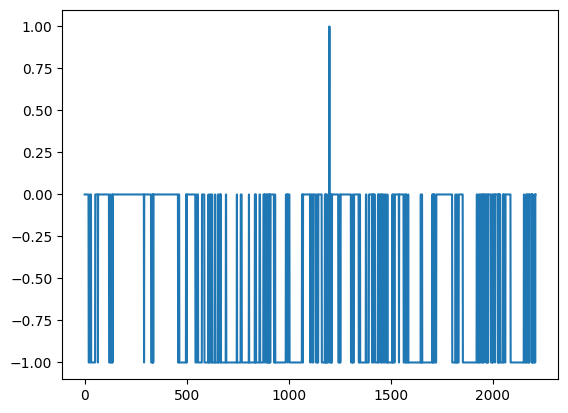

In [ ]:
plt.plot(eigenvector['s'].values)

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']=='chr1')].reset_index(drop=True)
eigenvec_array = eigenvector['E1'].values
max_abs_value = np.max(eigenvec_array)
thres = np.linspace(-max_abs_value, max_abs_value, 4)
s_array = discretize_array(eigenvec_array, thres)-2
eigenvector['s'] = s_array

248956422


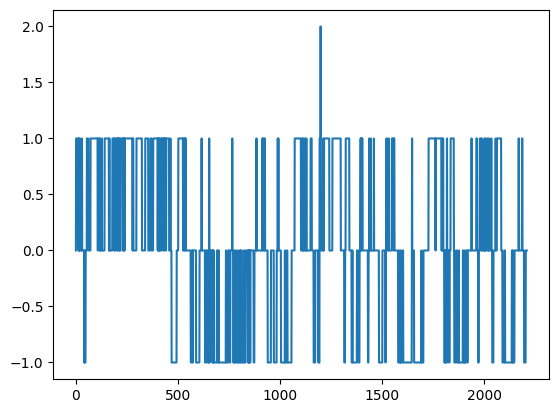

In [ ]:
plt.plot(eigenvector['s'].values)

In [ ]:
#########################################################################
########### CREATOR: SEBASTIAN KORSAK, WARSAW 2024 ######################
#########################################################################

from matplotlib.pyplot import figure
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance
from tqdm import tqdm
import pyBigWig
import random as rd
from itertools import groupby
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None

chrs = {0:'chr1',1:'chr2',2:'chr3',3:'chr4',4:'chr5',5:'chr6',6:'chr7',7:'chr8',
          8:'chr9',9:'chr10',10:'chr11',11:'chr12',12:'chr13',13:'chr14',14:'chr15',
          15:'chr16',16:'chr17',17:'chr18',18:'chr19',19:'chr20',20:'chr21',21:'chr22',
          22:'chrX',23:'chrY'}

chrom_lengths_array = np.array([0,248387328,242696752,201105948,193574945,
                 182045439,172126628,160567428,146259331,
                 150617247,134758134,135127769,133324548,
                 113566686,101161492,99753195,96330374,
                 84276897,80542538,61707364,66210255,
                 45090682,51324926,154259566,62460029])

chrom_sizes = {'chr1':248387328,'chr2':242696752,'chr3':201105948,'chr4':193574945,
               'chr5':182045439,'chr6':172126628,'chr7':160567428,'chr8':146259331,
               'chr9':150617247,'chr10':134758134,'chr11':135127769,'chr12':133324548,
               'chr13':113566686,'chr14':101161492,'chr15':99753195,'chr16':96330374,
               'chr17':84276897,'chr18':80542538,'chr19':61707364,'chr20':66210255,
               'chr21':45090682,'chr22':51324926,'chrX':154259566,'chrY':62460029}

def min_max_normalize(matrix, Min=0, Max=1):
    # Calculate the minimum and maximum values of the matrix
    matrix = np.nan_to_num(matrix)
    min_val = np.min(matrix)
    max_val = np.max(matrix)

    # Normalize the matrix using the min-max formula
    normalized_matrix = Min + (Max - Min) * ((matrix - min_val) / (max_val - min_val))

    return normalized_matrix

chrom_strength = 1-min_max_normalize(chrom_lengths_array[1:])

def get_coordinates_mm(mm_vec):
    '''
    It returns the corrdinate matrix V (N,3) of a .pdb file.
    The main problem of this function is that coordiantes are not always in 
    the same column position of a .pdb file. Do changes appropriatelly,
    in case that the data aren't stored correctly. 
    
    Input:
    file (Openmm Qunatity): an OpenMM vector of the form
    Quantity(value=[Vec3(x=0.16963918507099152, y=0.9815883636474609, z=-1.4776774644851685), 
    Vec3(x=0.1548253297805786, y=0.9109517931938171, z=-1.4084612131118774), 
    Vec3(x=0.14006929099559784, y=0.8403329849243164, z=-1.3392155170440674), 
    Vec3(x=0.12535107135772705, y=0.7697405219078064, z=-1.269935131072998),
    ...,
    unit=nanometer)
    
    Output:
    V (np.array): the matrix of coordinates
    '''
    V = list()

    for i in range(len(mm_vec)):
        x, y ,z = mm_vec[i][0]._value, mm_vec[i][1]._value, mm_vec[i][2]._value
        V.append([x, y, z])
    
    return np.array(V)

def get_coordinates_cif(file):
    '''
    It returns the corrdinate matrix V (N,3) of a .pdb file.
    The main problem of this function is that coordiantes are not always in 
    the same column position of a .pdb file. Do changes appropriatelly,
    in case that the data aren't stored correctly. 
    
    Input:
    file (str): the path of the .cif file.
    
    Output:
    V (np.array): the matrix of coordinates
    '''
    V = list()
    
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("ATOM"):
                columns = line.split()
                x = eval(columns[10])
                y = eval(columns[11])
                z = eval(columns[12])
                V.append([x, y, z])
    
    return np.array(V)

def get_heatmap(mm_vec,viz=False,save=False,path=''):
    '''
    It returns the corrdinate matrix V (N,3) of a .pdb file.
    The main problem of this function is that coordiantes are not always in 
    the same column position of a .pdb file. Do changes appropriatelly,
    in case that the data aren't stored correctly.
    
    Input:
    file (Openmm Qunatity): an OpenMM vector of the form 
    Quantity(value=[Vec3(x=0.16963918507099152, y=0.9815883636474609, z=-1.4776774644851685),
    Vec3(x=0.1548253297805786, y=0.9109517931938171, z=-1.4084612131118774),
    Vec3(x=0.14006929099559784, y=0.8403329849243164, z=-1.3392155170440674),
    Vec3(x=0.12535107135772705, y=0.7697405219078064, z=-1.269935131072998),
    ...,
    unit=nanometer)
    
    Output:
    H (np.array): a heatmap of the 3D structure.
    '''
    V = get_coordinates_mm(mm_vec)
    mat = distance.cdist(V, V, 'euclidean') # this is the way \--/
    mat = 1/(mat+1)
    
    if save: np.save('sim_heat.npy',mat)
    
    if viz:
        figure(figsize=(25, 20))
        plt.imshow(mat,cmap="coolwarm",vmax=np.average(mat)+3*np.std(mat),vmin=np.average(mat)-3*np.std(mat))
        plt.savefig(path+'heatmap.svg',format='svg',dpi=500)
        plt.savefig(path+'heatmap.pdf',format='pdf',dpi=500)
        plt.close()
    return mat

def compute_averages(arr1, N2):
    # Calculate the window size
    window_size = len(arr1) // N2

    # Reshape the array into a 2D array with the specified window size
    reshaped_arr = arr1[:N2 * window_size].reshape(N2, -1)

    # Calculate the average along the specified axis (axis=1)
    averaged_arr = np.mean(reshaped_arr, axis=1)

    return averaged_arr

def import_bed(bed_file,N_beads,coords=None,chrom=None,save_path='',shuffle=False,seed=0,n_chroms = 22):
    # Load compartment dataset
    np.random.seed(seed)
    comps_df = pd.read_csv(bed_file,header=None,sep='\t')

    # Find maximum coordinate of each chromosome
    print('Cleaning and transforming subcompartments dataframe...')
    if chrom!=None:
        comps_df = comps_df[(comps_df[0]==chrom)&(comps_df[1]>coords[0]) & (comps_df[2]<coords[1])].reset_index(drop=True)
    chrom_idxs = np.arange(n_chroms).astype(int)
    if shuffle: np.random.shuffle(chrom_idxs)
    chrom_ends = np.cumsum(np.insert(chrom_lengths_array[1:][chrom_idxs], 0, 0)) if chrom==None else np.array([0,chrom_sizes[chrom]])
    
    # Sum bigger chromosomes with the maximum values of previous chromosomes
    if chrom==None:
        for count, i in enumerate(chrom_idxs):
            comps_df[1][comps_df[0]==chrs[i]]=comps_df[1][comps_df[0]==chrs[i]]+chrom_ends[count]
            comps_df[2][comps_df[0]==chrs[i]]=comps_df[2][comps_df[0]==chrs[i]]+chrom_ends[count]

    # Convert genomic coordinates to simulation beads
    resolution = chrom_ends[-1]//N_beads if chrom==None else (coords[1]-coords[0])//N_beads
    chrom_ends = np.array(chrom_ends)//resolution
    chrom_ends[-1] = N_beads
    np.save(save_path+'chrom_lengths.npy',chrom_ends)
    if chrom!=None:
        comps_df[1], comps_df[2] = comps_df[1]-coords[0], comps_df[2]-coords[0]
    comps_df[1], comps_df[2] = comps_df[1]//resolution, comps_df[2]//resolution
    
    # Convert compartemnts to vector
    print('Building subcompartments_array...')
    comps_array = np.zeros(N_beads)
    for i in tqdm(range(len(comps_df))):
        if comps_df[3][i].startswith('A.1') or comps_df[3][i].startswith('A1'):
            val = 2
        elif comps_df[3][i].startswith('A.2') or comps_df[3][i].startswith('A2') or comps_df[3][i].startswith('A'):
            val = 1
        elif comps_df[3][i].startswith('B.2') or comps_df[3][i].startswith('B2'):
            val = -2
        elif comps_df[3][i].startswith('B.1') or comps_df[3][i].startswith('B1') or comps_df[3][i].startswith('B'):
            val = -1
        comps_array[comps_df[1][i]:comps_df[2][i]] = val

    np.save(save_path+'compartments.npy',comps_array)
    np.save(save_path+'chrom_idxs.npy',chrom_idxs)
    print('Done')
    return comps_array.astype(int), chrom_ends.astype(int), chrom_idxs.astype(int)

def align_comps(comps,ms,chrom_ends):
    for i in range(len(chrom_ends)-1):
        start, end = chrom_ends[i], chrom_ends[i+1]
        mms = ms[(start<ms)&(ms<end)]
        comps_with_loops = comps[mms]
        Aloops = np.count_nonzero(comps_with_loops>0)
        Bloops = np.count_nonzero(comps_with_loops<0)
        if Aloops>Bloops: comps[start:end] = -comps[start:end]
    return comps

def integers_to_hex_colors(start, end):
    # Generate a range of integers
    integers = np.arange(start, end + 1)

    # Map each integer to a rainbow color and convert to hex format
    rgb_colors = plt.cm.rainbow(integers / max(integers))
    hex_colors = [to_hex(color) for color in rgb_colors]

    return hex_colors

def write_chrom_colors(chrom_ends,chrom_idxs,name='MultiMM_chromosome_colors.cmd'):    
    colors = integers_to_hex_colors(0, len(chrom_ends)+1)
    
    content = ''
    for i in range(len(chrom_ends)-1):
        content+=f'color {colors[chrom_idxs[i]]} :.{chr(64+1+i)}\n'

    with open(name, 'w') as f:
        f.write(content)

def min_max_trans(x):
    return (x-x.min())/(x.max()-x.min())

def process_file(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            columns = line.strip().split('\t')
            # Repeat the second and fourth columns, and add a new column with 1
            new_line = f"{columns[0]}\t{columns[1]}\t{columns[1]}\t{columns[2]}\t{columns[3]}\t{columns[3]}\t1\n"
            outfile.write(new_line)

def downsample_arrays(ms, ns, cs, ds, down_prob):
    assert len(ms) == len(ns) == len(cs) == len(ds), "Arrays must have the same length"
    
    # Generate a mask of indices to keep
    mask = np.random.rand(len(ms)) < down_prob
    indices = np.where(mask)[0]

    # Apply the same mask to all arrays
    ms_downsampled = ms[indices]
    ns_downsampled = ns[indices]
    cs_downsampled = cs[indices]
    ds_downsampled = ds[indices]

    return ms_downsampled, ns_downsampled, cs_downsampled, ds_downsampled

def import_mns_from_bedpe(bedpe_file, N_beads, coords=None, chrom=None, threshold=0, min_loop_dist=2, path='', down_prob=1.0, shuffle=False, seed=0, n_chroms=22):
    # Import loops
    np.random.seed(seed)
    loops = pd.read_csv(bedpe_file,header=None,sep='\t')
    chrom_idxs = np.arange(n_chroms).astype(int)
    if shuffle: np.random.shuffle(chrom_idxs)
    if chrom!=None:
        loops = loops[(loops[0]==chrom)&(loops[1]>coords[0])&(loops[2]<coords[1])&(loops[4]>coords[0])&(loops[5]<coords[1])].reset_index(drop=True)
    chrom_ends = np.cumsum(np.insert(chrom_lengths_array[1:][chrom_idxs], 0, 0)) if chrom==None else np.array([0,chrom_sizes[chrom]])
    print('Cleaning and transforming loops dataframe...')
    
    # Sum bigger chromosomes with the maximum values of previous chromosomes
    if chrom==None:
        for count, i in enumerate(chrom_idxs):
            loops[1][loops[0]==chrs[i]]=loops[1][loops[0]==chrs[i]]+chrom_ends[count]
            loops[2][loops[0]==chrs[i]]=loops[2][loops[0]==chrs[i]]+chrom_ends[count]
            loops[4][loops[3]==chrs[i]]=loops[4][loops[3]==chrs[i]]+chrom_ends[count]
            loops[5][loops[3]==chrs[i]]=loops[5][loops[3]==chrs[i]]+chrom_ends[count]
    
    # Convert genomic coordinates to simulation beads
    resolution = int(np.max(loops[5].values))//N_beads if chrom==None else (coords[1]-coords[0])//N_beads
    chrom_ends = np.array(chrom_ends)//resolution
    chrom_ends[-1] = N_beads
    np.save(path+'chrom_lengths.npy',chrom_ends)
    if chrom!=None:
        loops[1], loops[2], loops[4], loops[5] = loops[1]-coords[0], loops[2]-coords[0], loops[4]-coords[0], loops[5]-coords[0]
    loops[1], loops[2], loops[4], loops[5] = loops[1]//resolution, loops[2]//resolution, loops[4]//resolution, loops[5]//resolution
    loops['ms'] = (loops[1].values+loops[2].values)//2
    loops['ns'] = (loops[4].values+loops[5].values)//2
    loops['Total Count'] = loops.groupby(['ms', 'ns'])[6].transform('mean')
    counts = loops['Total Count'].values
    
    # Filter the ones above the threshold
    print('Importing loops...')
    mns, cs = np.vstack((loops['ms'].values[counts>threshold], loops['ns'].values[counts>threshold])), counts[counts>threshold]
    mns, idxs = np.unique(mns,axis=1,return_index=True)
    cs = cs[idxs]
    ms, ns = mns[0,:], mns[1,:]
    ms[ms>=N_beads],ns[ns>=N_beads]=N_beads-1, N_beads-1
    ms,ns,cs = ms[ns>ms+min_loop_dist], ns[ns>ms+min_loop_dist], cs[ns>ms+min_loop_dist]
    ds = 0.1+0.1*min_max_trans(1/cs**2/3) if not np.all(cs==cs[0]) else np.ones(len(ms))

    # Perform some data cleaning
    mask = (ns-ms)!=0
    ms = ms[mask]
    ns = ns[mask]
    ds= ds[mask]
    cs = cs[mask]

    if down_prob<1.0:
        ms, ns, cs, ds = downsample_arrays(ms, ns, cs, ds, down_prob)

    avg_ls = np.average(ns-ms)
    print('Average loop size:',avg_ls)

    N_loops = len(ms)
    np.save(path+'chrom_idxs.npy',chrom_idxs)
    np.save(path+'ms.npy',ms)
    np.save(path+'ns.npy',ns)
    np.save(path+'ds.npy',ds)
    print('Done! Number of loops is ',N_loops)
    return ms.astype(int), ns.astype(int), ds, chrom_ends.astype(int), chrom_idxs.astype(int)

def generate_arrays(N_loops, N, l=6):
    # Generate array ms with random integers between 0 and N (exclusive)
    ms = np.random.randint(0, N, size=N_loops)

    # Generate array ns by adding a random integer from an exponential distribution with average l
    ns = ms + np.round(np.random.exponential(l, size=N_loops)).astype(int)
    ns = np.maximum(ns, 3)
    ns = np.minimum(ns, N-1)

    # Define array ks with weights randomly distributed in the scale of 50 to 3000
    ks = np.random.uniform(50, 3000, N_loops)

    return ms, ns, ks

def shuffle_blocks(array):
    # Identify the unique blocks of repeating elements
    unique_blocks = [list(g) for k, g in groupby(array)]
    
    # Shuffle the unique blocks
    np.random.shuffle(unique_blocks)
    
    # Concatenate the shuffled blocks to create the final shuffled array
    shuffled_array = [elem for block in unique_blocks for elem in block]

    return shuffled_array

def import_bw(bw_path,N_beads,coords=None,chrom=None,viz=False,binary=False,path='',norm=False,shuffle=False,seed=0,n_chroms=22):
    '''
    Imports .BigWig data and outputs compartments.

    It assumes that higher signal coresponds to B compartment.

    In case that you would like to switch the sign then add flag sign=-1.
    '''
    # Open file
    np.random.seed(seed)
    bw = pyBigWig.open(bw_path)
    chrom_idxs = np.arange(n_chroms).astype(int)
    if shuffle: np.random.shuffle(chrom_idxs)
    print('Number of chromosomes:',n_chroms)

    # Compute the total length of chromosomes
    if chrom==None:
        chrom_length = 0
        lengths = list()
        for i in range(n_chroms):
            chrom_length += bw.chroms(chrs[chrom_idxs[i]])
            lengths.append(bw.chroms(chrs[chrom_idxs[i]]))
        lengths = np.array(lengths)
        resolution = chrom_length//(2*N_beads)
        polymer_lengths = lengths//resolution
        np.save(path+'chrom_lengths.npy',polymer_lengths)

    # Import the downgraded signal
    print('Importing bw signal...')
    if chrom==None:
        genomewide_signal = list()
        for i in tqdm(range(n_chroms)):
            signal = bw.values(chrs[chrom_idxs[i]],0,-1, numpy=True)
            signal = np.nan_to_num(signal, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
            genomewide_signal.append(compute_averages(signal, polymer_lengths[i]))
        genomewide_signal = np.concatenate(genomewide_signal)
    else:
        genomewide_signal = bw.values(chrom,coords[0],coords[1], numpy=True)
        genomewide_signal = np.nan_to_num(genomewide_signal, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
    bw.close()

    genomewide_signal = compute_averages(genomewide_signal,N_beads)
    if norm: genomewide_signal = (genomewide_signal-np.mean(genomewide_signal)+3*np.std(genomewide_signal))/np.std(genomewide_signal)
    
    # Transform signal to binary or adjuct it to have zero mean
    if binary:
        genomewide_signal[genomewide_signal>0] = -1
        genomewide_signal[genomewide_signal<=0] = 1
        
        # Subtitute zeros with random spin states
        mask = genomewide_signal==0
        n_zeros = np.count_nonzero(mask)
        nums = np.array(rd.choices([-1,1],k=n_zeros))
        genomewide_signal[mask] = nums
    
    print('Done!\n')

    # Plotting
    if viz:
        figure(figsize=(25, 5), dpi=100)
        xax = np.arange(len(genomewide_signal))
        plt.fill_between(xax,genomewide_signal, where=(genomewide_signal>np.mean(genomewide_signal)),alpha=0.50,color='purple')
        plt.fill_between(xax,genomewide_signal, where=(genomewide_signal<np.mean(genomewide_signal)),alpha=0.50,color='orange')
        lines = np.cumsum(polymer_lengths//2)
        for i in range(n_chroms):
            plt.axvline(x=lines[i], color='b')
        plt.xlabel('Genomic Distance',fontsize=16)
        plt.ylabel('BW signal renormalized',fontsize=16)
        plt.ylim((np.mean(genomewide_signal)-np.std(genomewide_signal),np.mean(genomewide_signal)+np.std(genomewide_signal)))
        plt.grid()
        plt.show()

    np.save(path+'signal.npy',genomewide_signal)
    
    return genomewide_signal

def get_gene_region(gene_tsv, gene_id=None, gene_name=None, window_size = 100000):
    '''
    Input a gene tsv and ouputs a region around the gene
    '''
    genes = pd.read_csv(gene_tsv,sep='\t')
    if gene_id!=None:
        print('Region will be define based on gene ID.')
        chrom = genes[genes['gene_id']==gene_id]['chromosome'].values[0]
        start = genes[genes['gene_id']==gene_id]['start'].values[0]
        end = genes[genes['gene_id']==gene_id]['end'].values[0]
    elif gene_name!=None:
        print('Region will be define based on gene name.')
        chrom = genes[genes['gene_id']==gene_id]['chromosome'].values[0]
        start = genes[genes['gene_id']==gene_id]['start'].values[0]
        end = genes[genes['gene_id']==gene_id]['end'].values[0]
    
    region = [max(0,int(start-window_size)), int(end+window_size)]
    return chrom, region

def discretize_array(arr, thresholds):
    """
    Discretize a NumPy array based on 4 thresholds.
    
    Parameters:
        arr (np.ndarray): Input array.
        thresholds (list or np.ndarray): List of 4 increasing threshold values.
        
    Returns:
        np.ndarray: Discretized array with integer labels from 0 to 4.
    """
    thresholds = np.sort(thresholds)
    return np.digitize(arr, bins=thresholds, right=False)

def get_eigenvector(eigenvec_tsv, chrom, region, N_beads, viz=False):
    resolution = (region[1]-region[0])//N_beads
    eigenvector = pd.read_csv(eigenvec_tsv,sep='\t')
    n_chroms = np.unique(eigenvector['chrom'].values)
    chrom_idxs = [0]
    for i in range(n_chroms):
        chr_idx = max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values)
        chrom_idxs.append(chr_idx)
    chrom_idxs = np.array(chrom_idxs)
    eigenvector = eigenvector[(eigenvector['chrom']==chrom)].reset_index(drop=True)
    eigenvec_array = eigenvector['E1'].values
    max_abs_value = np.max(eigenvec_array)
    thres = np.linspace(-max_abs_value, max_abs_value, 4)
    s_array = discretize_array(eigenvec_array, thres)-2
    eigenvector['s'] = s_array
    eigenvector = eigenvector[(eigenvector['start']<region[0])&(eigenvector['end']>region[0])].reset_index(drop=True)
    eigenvector['start'] = (eigenvector['start']-region[0])//resolution
    eigenvector['end'] = (eigenvector['end']-region[0])//resolution
    eigenvec_array = eigenvector['E1'].values
    starts, ends = eigenvector['start'].values, eigenvector['end'].values
    Ss = eigenvector['s'].values
    spins = np.zeros(N_beads)
    for i in range(len(starts)):
         spins[starts[i]:ends[i]] = Ss[i]

    if viz:
        plt.plot(eigenvec_array)
        plt.ylabel('Eigenvector')
        plt.xlabel('Genomic Distance')
        plt.show()
    return spins, chrom_idxs

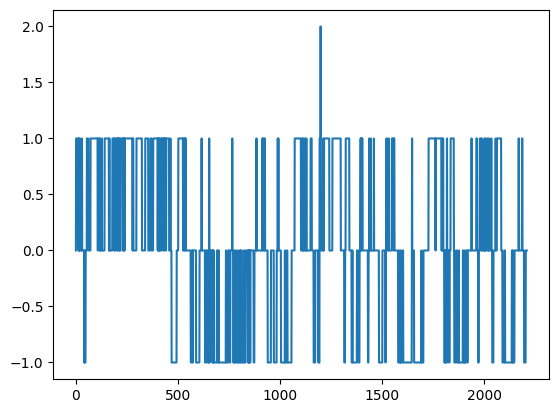

In [ ]:
plt.plot(eigenvector['s'].values)

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']=='chr1')].reset_index(drop=True)
eigenvec_array = eigenvector['E1'].values
max_abs_value = np.max(eigenvec_array)
thres = np.linspace(-max_abs_value, max_abs_value, 4)
s_array = discretize_array(eigenvec_array, thres)-2
eigenvector['s'] = s_array

248956422


248956422


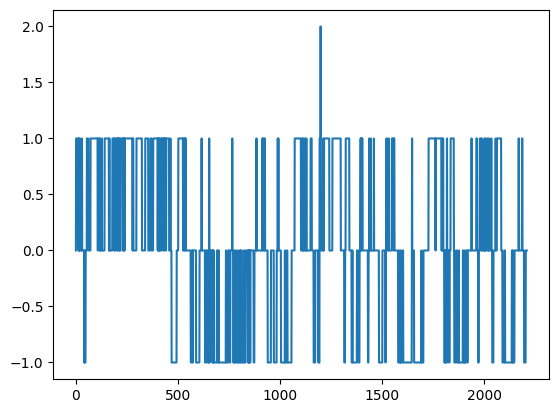

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']=='chr1')].reset_index(drop=True)
eigenvec_array = eigenvector['E1'].values
max_abs_value = np.max(eigenvec_array)
thres = np.linspace(-max_abs_value, max_abs_value, 4)
s_array = discretize_array(eigenvec_array, thres)-2
eigenvector['s'] = s_array
plt.plot(eigenvector['s'].values)

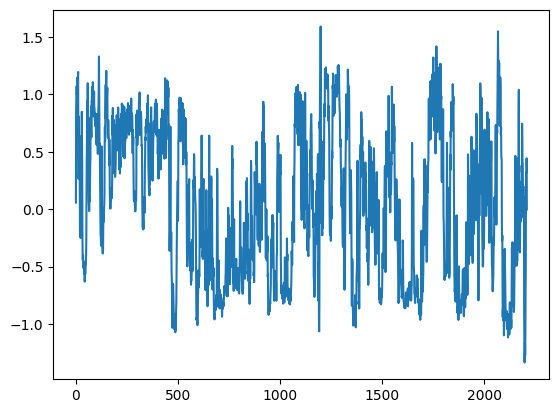

In [ ]:
plt.plot(eigenvector['E1'].values)

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']=='chr1')].reset_index(drop=True)
eigenvec_array = eigenvector['E1'].values
thres = np.linspace(np.min(eigenvec_array), np.max(eigenvec_array), 4)
s_array = discretize_array(eigenvec_array, thres)-2
eigenvector['s'] = s_array)

SyntaxError: unmatched ')' (<ipython-input-34-c12bdb59c4e2>, line 12)

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']=='chr1')].reset_index(drop=True)
eigenvec_array = eigenvector['E1'].values
thres = np.linspace(np.min(eigenvec_array), np.max(eigenvec_array), 4)
s_array = discretize_array(eigenvec_array, thres)-2
eigenvector['s'] = s_array

248956422


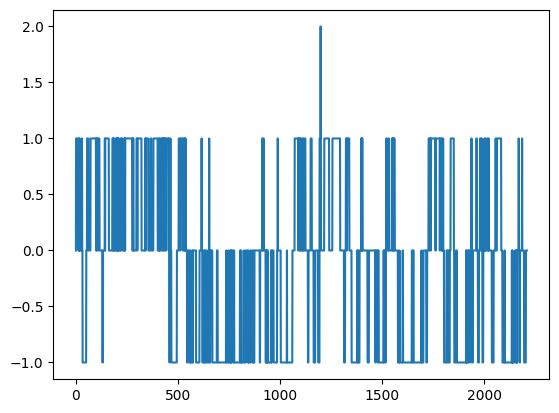

In [ ]:
plt.plot(s_array)

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']=='chr1')].reset_index(drop=True)
eigenvec_array = eigenvector['E1'].values
thres = np.linspace(np.min(eigenvec_array), np.max(eigenvec_array), 3)
s_array = discretize_array(eigenvec_array, thres)-2
eigenvector['s'] = s_array

248956422


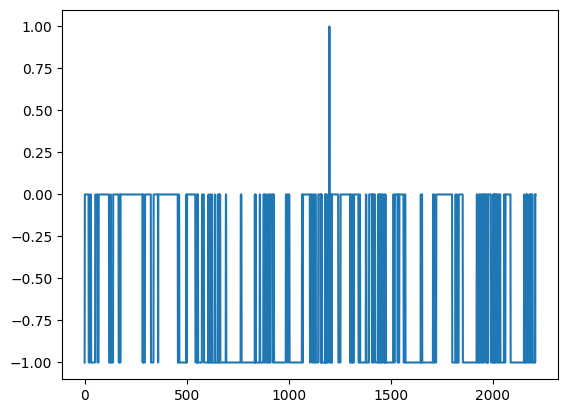

In [ ]:
plt.plot(s_array)

In [ ]:
eigenvector = pd.read_csv('/home/skorsak/Data/Nextflow_Project/eigenvector_track_gm12878.tsv',sep='\t')
n_chroms = len(np.unique(eigenvector['chrom'].values))
chrom_idxs = [0]
for i in range(1):
    print(max(eigenvector[eigenvector['chrom'] == f'chr{i+1}']['end'].values))
    chrom_idxs.append(chr_idx)
chrom_idxs = np.array(chrom_idxs)
eigenvector = eigenvector[(eigenvector['chrom']=='chr1')].reset_index(drop=True)
eigenvec_array = eigenvector['E1'].values
thres = np.linspace(np.min(eigenvec_array), np.max(eigenvec_array), 4)
s_array = discretize_array(eigenvec_array, thres)-2
eigenvector['s'] = s_array

248956422
